***1. Perform exploratory data analysis (EDA) on*** Malaria cell image dataset ***to demonstrate the dataset characteristics by summarising the dataset and formalising the rationale of the task***

**Rationale of this task:**

   The rationale of this task is to use a pretrained deep Learning model to predict the Malaria blood cells just by giving the cell images. Identifying the Malaria presence in the cell images using the models to identify the Malaria disease with high accuracy could save time and human labor. In this task, I have used three different models and hyper tuned one model with highest accuracy to get the best accuracy and evaluated the performance of the tuned model with general metrics including Precision and recall.


In [ ]:
#Importing libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, roc_curve, auc
import seaborn as sns
import random
from glob import glob
import os


In [ ]:
#global declarations
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [ ]:
# Set data directory
data_dir = "D:\Machine Learning\cell_images\cell_images"
target_classes = os.listdir(data_dir)
print(target_classes)


['Parasitized', 'Uninfected']


In [ ]:
#Data Preparation and DataFrame Creation for Infected and Uninfected Images
infected_images     = glob(os.path.join(data_dir, target_classes[0])+"/*.png")
uninfected_images   = glob(os.path.join(data_dir, target_classes[1])+"/*.png")

data = []

for image_path in (infected_images + uninfected_images):

        label = target_classes[0] if (target_classes[0] in image_path) else target_classes[1]
        data.append((image_path, label))


data_df = pd.DataFrame(data, columns=["image_path", "label"])
data_df.head()

,image_path,label
0,D:\Machine Learning\cell_images\cell_images\Pa...,Parasitized
1,D:\Machine Learning\cell_images\cell_images\Pa...,Parasitized
2,D:\Machine Learning\cell_images\cell_images\Pa...,Parasitized
3,D:\Machine Learning\cell_images\cell_images\Pa...,Parasitized
4,D:\Machine Learning\cell_images\cell_images\Pa...,Parasitized


### Data Exploration

Parasitized    13779
Uninfected     13779
Name: label, dtype: int64


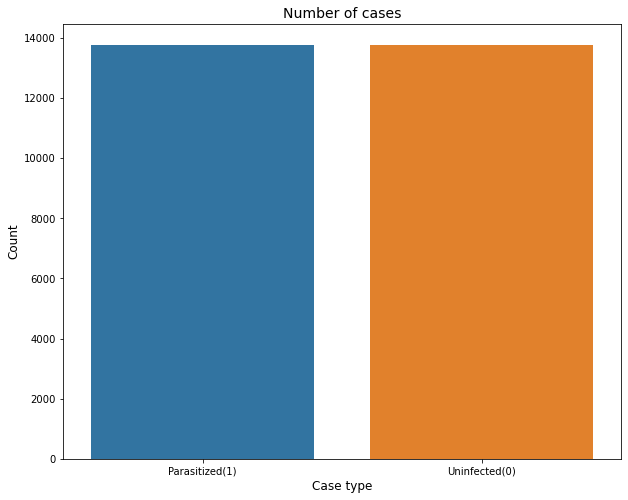

In [ ]:
# Get the counts for each class
sample_count = data_df['label'].value_counts()
print(sample_count)

# Plot the results
plt.figure(figsize=(10,8))
sns.barplot(x=sample_count.index, y= sample_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(sample_count.index)), ['Parasitized(1)', 'Uninfected(0)'])
plt.show()

**The dataset is balanced**

It is noted that the Malaria cell image data set is divided into two classes, Parasitized and Uninfected. Parasitized images are the blood cells which have Malaria disease and Uninfected are the blood cells that are not infected with Malaria disease. It can be found by manually examining the dataset that parasitized cell images are having the red-colored stain mark whereas the uninfected cell images are clear without the stains.  It is evident from this analysis that if the cells are diseased with Malaria, it will have stains.

  Both classes have 13779 images as per the count shown above.Hence, there is no data imbalance in the given data set. Also, the data is evenly distributed . As there is no imbalance and the data is distributed equally.So, none of the data augmentation techniques were used here to increase/decrease the data imbalance and to correct the data distribution.

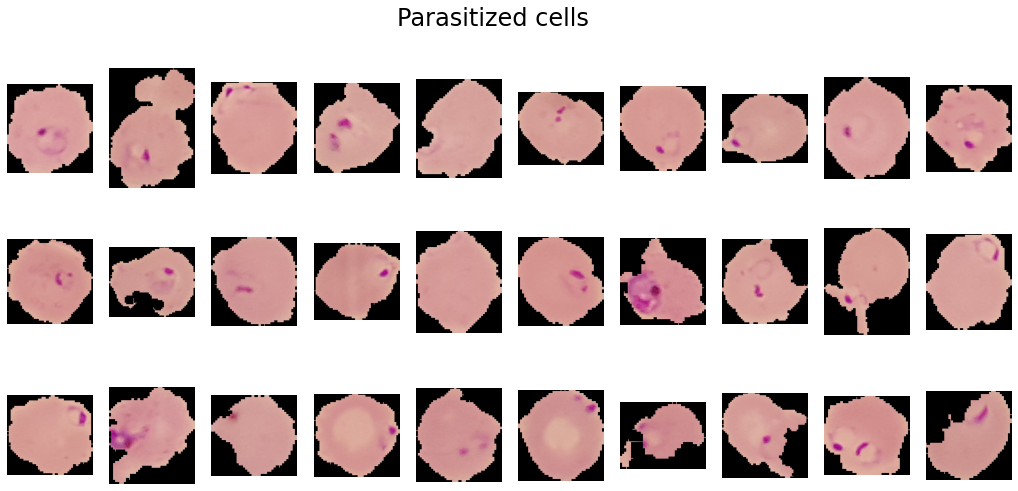

In [ ]:
fig, ax = plt.subplots(figsize=(18, 8))
fig.suptitle('Parasitized cells', fontsize=24)

for ind, img_src in enumerate(infected_images[:30]):
    plt.subplot(3, 10, ind+1)
    img = plt.imread(img_src)
    plt.axis('off')
    plt.imshow(img)

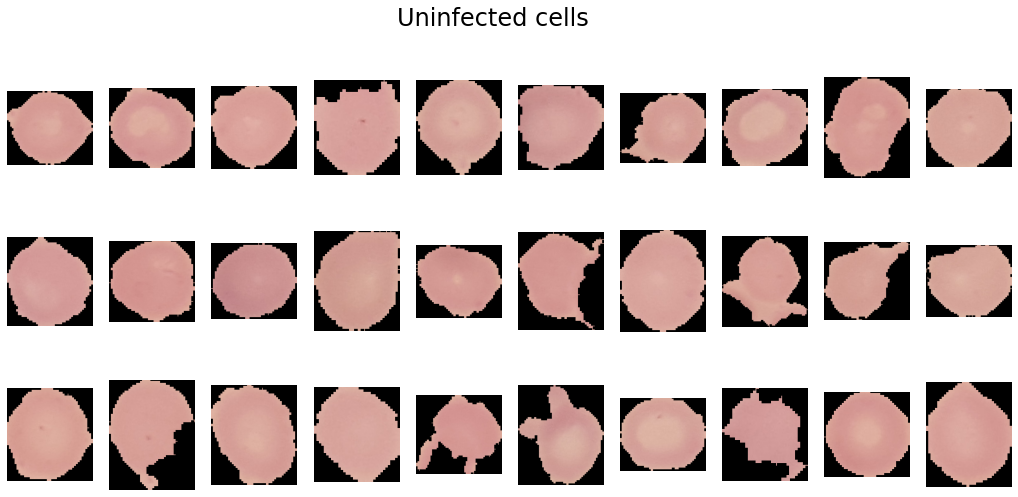

In [ ]:
fig, ax = plt.subplots(figsize=(18, 8))
fig.suptitle('Uninfected cells', fontsize=24)

for ind, img_src in enumerate(uninfected_images[:30]):
    plt.subplot(3, 10, ind+1)
    img = plt.imread(img_src)
    plt.axis('off')
    plt.imshow(img)

***2. Select suitable models for the task chosen and then pre-process your datain a suitable format to be fed to those models***

I selected the below models for the task -
VGG19,
VGG16,
CNN


**Pre-processing data for training and validation :**
Since the data is balanced, I split the data set into train and test to fit into the model. To do that I have split into a ratio of 0.2 to validate the model and 0.3 to test the model.

In [ ]:
# Splitting the data into train and test sets using train_test_split function
train_df, test_df = train_test_split(data_df, test_size=0.30, random_state=42)

# Further splitting the train set into train and validation sets using train_test_split function
train_df, validate_df = train_test_split(train_df, test_size=0.20, random_state=42)

# Resetting the indices of train_df, validate_df, and test_df
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [ ]:
# Calculating the total number of samples in the train, validation, and test sets
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
total_test = test_df.shape[0]

# Setting the batch size for training the model
batch_size=16

# Printing the total number of samples in the train, validation, and test sets
print(f"Total training samples : {len(train_df)}\nTotal validation samples : {len(validate_df)}\nTotal Test samples : {len(test_df)}")

Total training samples : 15432
Total validation samples : 3858
Total Test samples : 8268


In [ ]:
# Applying Augmentation to genearate images with different angles, shift, flips..
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

validation_datagen = ImageDataGenerator(rescale=1./255)


***3. Build, train and validate the models***

# VGG 19

In [ ]:
#Importing libraries for the model
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers import  Adam
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg16 import VGG16

In [ ]:
#Training and evaluation of VGG19
x_train_vgg =  train_datagen.flow_from_dataframe(dataframe = train_df,  x_col='image_path', y_col='label',  class_mode='categorical',target_size=(224,224), shuffle=False, batch_size=10, seed=10)
x_val_vgg = validation_datagen.flow_from_dataframe(dataframe = validate_df,  x_col='image_path', y_col='label',class_mode='categorical',  target_size=(224,224), shuffle=False, batch_size=10, seed=10)

# Importing and Initializing the VGG19 Model
vgg19_model = VGG19(input_shape=(224,224,3), weights='imagenet',include_top=False)

# Initializing the Sequential Model
model=Sequential()

# Adding the VGG19 model as a layer to the Sequential Model
model.add(vgg19_model)

# Flattening the output from the VGG19 model
model.add(Flatten())

#Adding a Dense layer with 1024 units and ReLU activation
model.add(Dense(1024,activation='relu'))

# Adding a Dropout layer to prevent overfitting
model.add(Dropout(0.5))

# Adding the final Dense layer with 2 units and softmax activation
model.add(Dense(2,activation='softmax'))

# Compiling the model with Adam optimizer, learning rate of 1e-4, and categorical cross-entropy loss
model.compile(optimizer=Adam(learning_rate=1e-4),loss='categorical_crossentropy',metrics=['accuracy'])

# Training the model
model_history = model.fit(
x_train_vgg,
steps_per_epoch=100,
validation_data=x_val_vgg,
validation_steps=100,
epochs = 10)



Found 15432 validated image filenames belonging to 2 classes.
Found 3858 validated image filenames belonging to 2 classes.
Epoch 1/10
100/100 [==============================] - 92s 739ms/step - loss: 0.7284 - accuracy: 0.4890 - val_loss: 0.6931 - val_accuracy: 0.4820
Epoch 2/10
100/100 [==============================] - 78s 776ms/step - loss: 0.6931 - accuracy: 0.4970 - val_loss: 0.6930 - val_accuracy: 0.5180
Epoch 3/10
100/100 [==============================] - 76s 754ms/step - loss: 0.6933 - accuracy: 0.4950 - val_loss: 0.6930 - val_accuracy: 0.5180
Epoch 4/10
100/100 [==============================] - 59s 586ms/step - loss: 0.6931 - accuracy: 0.5150 - val_loss: 0.6929 - val_accuracy: 0.5180
Epoch 5/10
100/100 [==============================] - 55s 547ms/step - loss: 0.6931 - accuracy: 0.5100 - val_loss: 0.6929 - val_accuracy: 0.5180
Epoch 6/10
100/100 [==============================] - 55s 550ms/step - loss: 0.6931 - accuracy: 0.5050 - val_loss: 0.6929 - val_accuracy: 0.5180
Epoch 7

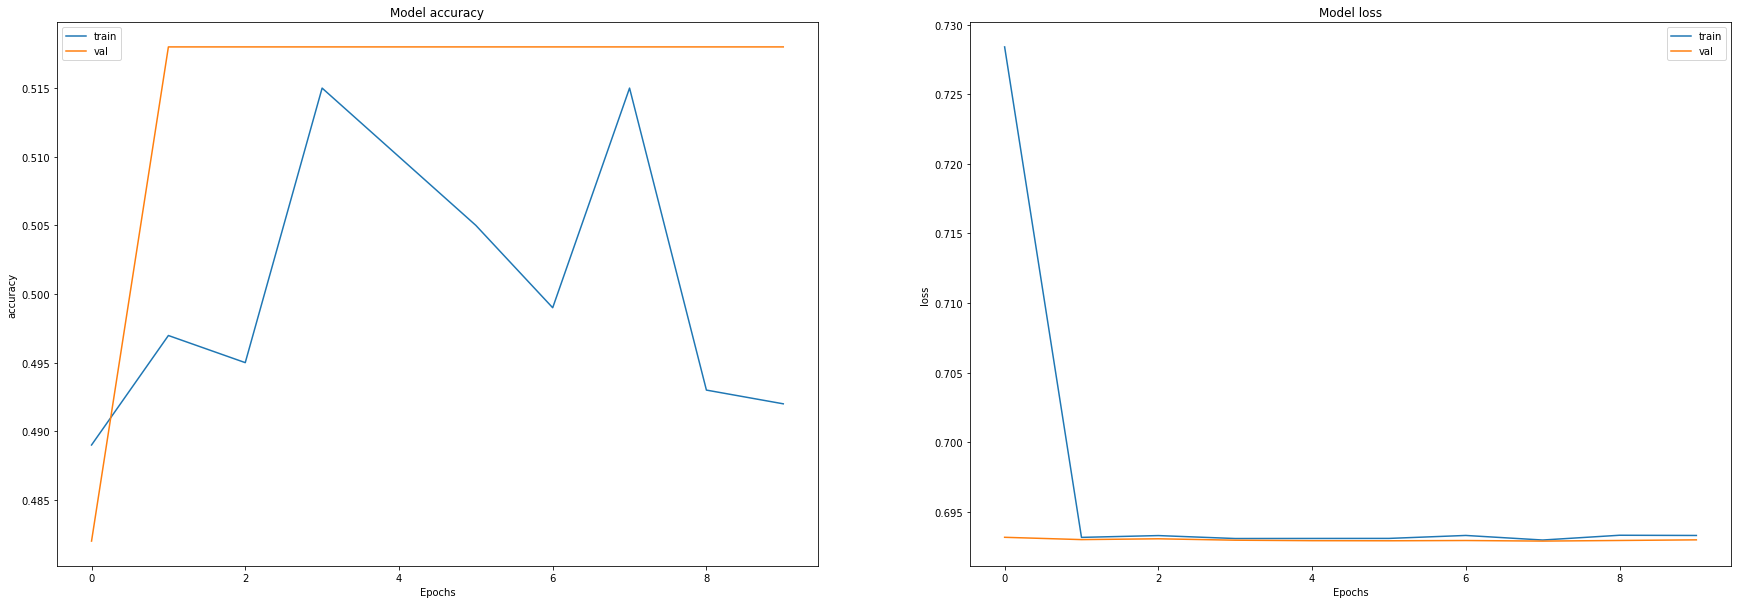

In [ ]:
# Creating subplots with 1 row and 2 columns, and specifying the figure size
fig, ax = plt.subplots(1, 2, figsize = (30, 10))
ax = ax.ravel()

# Iterating over the metrics ["accuracy", "loss"] and Plotting the metric for the training and validation data
for i, metric in enumerate(["accuracy", "loss"]):
    ax[i].plot(model_history.history[metric])
    ax[i].plot(model_history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [ ]:
model.evaluate(x_val_vgg)

386/386 [==============================] - 57s 146ms/step - loss: 0.6932 - accuracy: 0.4987


[0.6931760907173157, 0.4987039864063263]

# validation loss = 0.69
# validation Accuracy = ~49%

The model accuracy is around 50.Performs poor, maybe the model is too complex

# VGG16

In [ ]:
# Using the flow_from_dataframe method to generate batches of training data from a DataFrame
x_train_vgg16 = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='label',
    class_mode='binary',
    target_size=IMAGE_SIZE,
    shuffle=False,
    batch_size=10,
    seed=10
)

# Using the flow_from_dataframe method to generate batches of validation data from a DataFrame
x_val_vgg16 = validation_datagen.flow_from_dataframe(
    dataframe=validate_df,
    x_col='image_path',
    y_col='label',
    class_mode='binary',
    target_size=IMAGE_SIZE,
    shuffle=False,
    batch_size=10,
    seed=10
)


Found 15432 validated image filenames belonging to 2 classes.
Found 3858 validated image filenames belonging to 2 classes.


In [ ]:
 # Import VGG16 model and set its input shape to (128,128,3)
vgg16 = VGG16(input_shape=(128,128,3), weights='imagenet', include_top=False)


# Freeze all the layers in the VGG16 model so that their weights will not be updated during training
for layer in vgg16.layers:
    layer.trainable = False

# Add classification head
x = Flatten()(vgg16.output)
x = Dense(4096)(x)
prediction = Dense(1, activation='sigmoid')(x)

vgg16_model = Model(inputs=vgg16.input, outputs=prediction)
vgg16_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0   

In [ ]:
# Compile the VGG16 model with Adam optimizer, binary crossentropy loss, and accuracy metric
vgg16_model.compile(optimizer='adam',
              loss=['binary_crossentropy'],
              metrics=["accuracy"])

history_vgg16 = vgg16_model.fit(x_train_vgg16,
                    epochs =30,
                    steps_per_epoch=100,
                    validation_data = x_val_vgg16,
                    validation_steps=100,
                    batch_size=10)

Epoch 1/30
100/100 [==============================] - 16s 148ms/step - loss: 2.4412 - accuracy: 0.7580 - val_loss: 0.3123 - val_accuracy: 0.8670
Epoch 2/30
100/100 [==============================] - 16s 155ms/step - loss: 0.3128 - accuracy: 0.8720 - val_loss: 0.2392 - val_accuracy: 0.9050
Epoch 3/30
100/100 [==============================] - 16s 156ms/step - loss: 0.3783 - accuracy: 0.8440 - val_loss: 0.7602 - val_accuracy: 0.7190
Epoch 4/30
100/100 [==============================] - 14s 142ms/step - loss: 0.3083 - accuracy: 0.8790 - val_loss: 0.4010 - val_accuracy: 0.8290
Epoch 5/30
100/100 [==============================] - 13s 134ms/step - loss: 0.2803 - accuracy: 0.8870 - val_loss: 0.3947 - val_accuracy: 0.8590
Epoch 6/30
100/100 [==============================] - 13s 134ms/step - loss: 0.3219 - accuracy: 0.8770 - val_loss: 0.2037 - val_accuracy: 0.9240
Epoch 7/30
100/100 [==============================] - 14s 137ms/step - loss: 0.3746 - accuracy: 0.8550 - val_loss: 0.2300 - val_ac

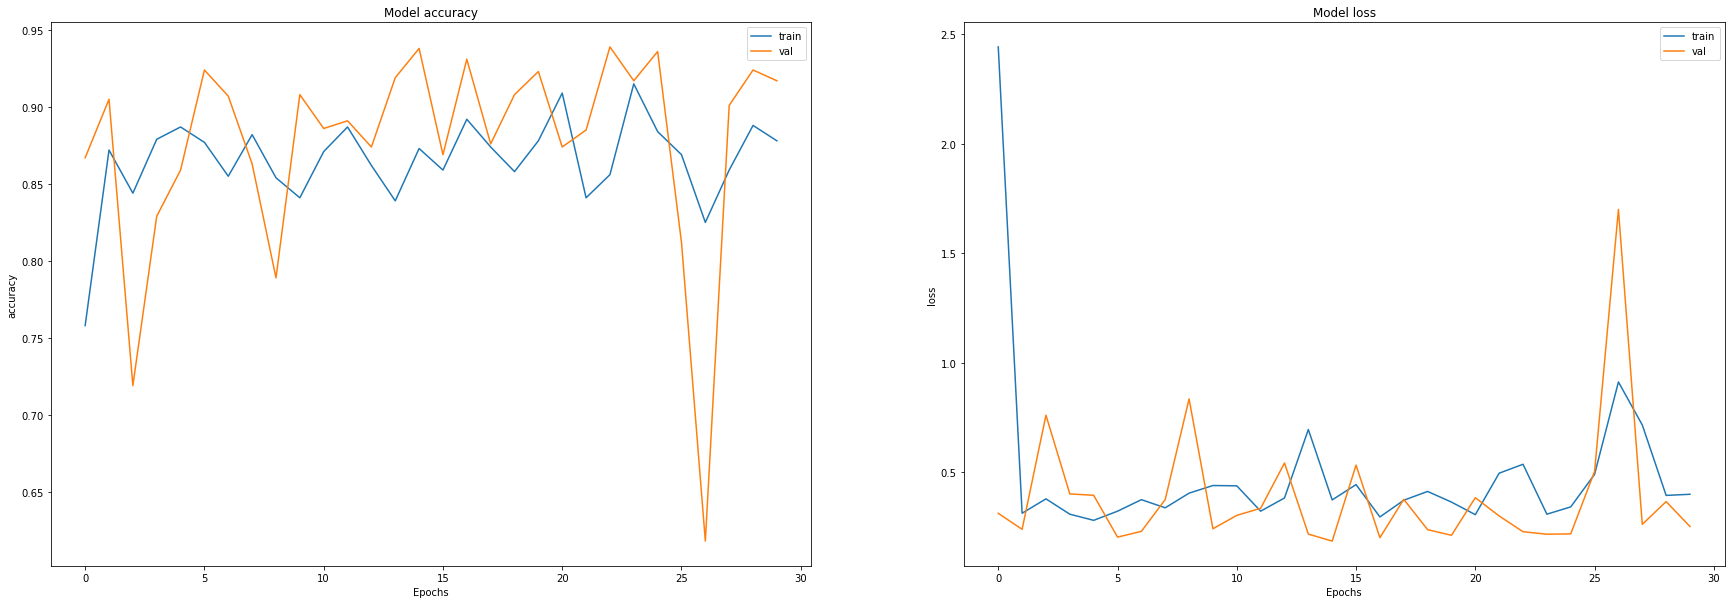

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (30, 10))
ax = ax.ravel()

for i, metric in enumerate(["accuracy", "loss"]):
    ax[i].plot(history_vgg16.history[metric])
    ax[i].plot(history_vgg16.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [ ]:
vgg16_model.evaluate(x_val_vgg16)   # evaluation on validation set

386/386 [==============================] - 16s 42ms/step - loss: 0.2672 - accuracy: 0.9059


[0.2671872675418854, 0.9059097766876221]

# Validation loss = 0.26

# Validation Accuracy = ~ 90.6 %

The VGG16 model has higher accuracy compared to the VGG19 model. possibly due to VGG19'S deeper architecture which may lead to overfitting and slower training.

# CUSTOM CNN ARCHITECTURE

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import  RMSprop

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='label',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=16
)

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    x_col='image_path',
    y_col='label',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=16
)



total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
total_test = test_df.shape[0]
batch_size=16

print(f"Training data : {total_train}\nvalidation data : {total_validate}\nTest data : {total_test}")

Found 15432 validated image filenames belonging to 2 classes.
Found 3858 validated image filenames belonging to 2 classes.
Training data : 15432
validation data : 3858
Test data : 8268


In [ ]:

# Define a sequential model
model = Sequential()

# Add convolutional layer with 32 filters, kernel size of (3,3), ReLU activation, and input shape
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
# Add max pooling layer with pool size of (2,2)
model.add(MaxPooling2D(pool_size=(2, 2)))
# Add batch normalization layer
model.add(BatchNormalization())

# Add convolutional layer with 32 filters, kernel size of (3,3), ReLU activation
model.add(Conv2D(32, (3, 3), activation='relu'))
# Add max pooling layer with pool size of (2,2)
model.add(MaxPooling2D(pool_size=(2, 2)))
# Add batch normalization layer
model.add(BatchNormalization())
# Add dropout layer with a rate of 0.5
model.add(Dropout(0.5))

# Add convolutional layer with 64 filters, kernel size of (3,3), ReLU activation
model.add(Conv2D(64, (3, 3), activation='relu'))
# Add batch normalization layer
model.add(BatchNormalization())
# Add max pooling layer with pool size of (2,2)
model.add(MaxPooling2D(pool_size=(2, 2)))
# Add dropout layer with a rate of 0.25
model.add(Dropout(0.25))

# Add flatten layer
model.add(Flatten())

# Add dense layer with 128 units and ReLU activation
model.add(Dense(128, activation='relu'))
# Add dropout layer with a rate of 0.5
model.add(Dropout(0.5))
# Add dense layer with 2 units and softmax activation
model.add(Dense(2, activation='softmax'))

# Define optimizer as RMSprop with learning rate of 0.0001
optimizer = RMSprop(learning_rate=0.0001)

# Compile model with categorical crossentropy loss and accuracy metric
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 63, 63, 32)        128       
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 61, 61, 32)        9248      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 30, 30, 32)        128       
_________________________________________________________________
dropout_58 (Dropout)         (None, 30, 30, 32)      

In [ ]:
# Fit the model and train for 30 epochs
epochs = 30
history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size
)

Epoch 1/30
964/964 [==============================] - 104s 108ms/step - loss: 0.6737 - accuracy: 0.6314 - val_loss: 0.7761 - val_accuracy: 0.6136
Epoch 2/30
964/964 [==============================] - 109s 113ms/step - loss: 0.6010 - accuracy: 0.6945 - val_loss: 0.7691 - val_accuracy: 0.7057
Epoch 3/30
964/964 [==============================] - 128s 132ms/step - loss: 0.4874 - accuracy: 0.7767 - val_loss: 0.9228 - val_accuracy: 0.6592
Epoch 4/30
964/964 [==============================] - 147s 153ms/step - loss: 0.4145 - accuracy: 0.8277 - val_loss: 0.5662 - val_accuracy: 0.7772
Epoch 5/30
964/964 [==============================] - 87s 90ms/step - loss: 0.3655 - accuracy: 0.8592 - val_loss: 0.5102 - val_accuracy: 0.8076
Epoch 6/30
964/964 [==============================] - 88s 91ms/step - loss: 0.3264 - accuracy: 0.8809 - val_loss: 0.2861 - val_accuracy: 0.8919
Epoch 7/30
964/964 [==============================] - 90s 93ms/step - loss: 0.2917 - accuracy: 0.9016 - val_loss: 0.2929 - val_a

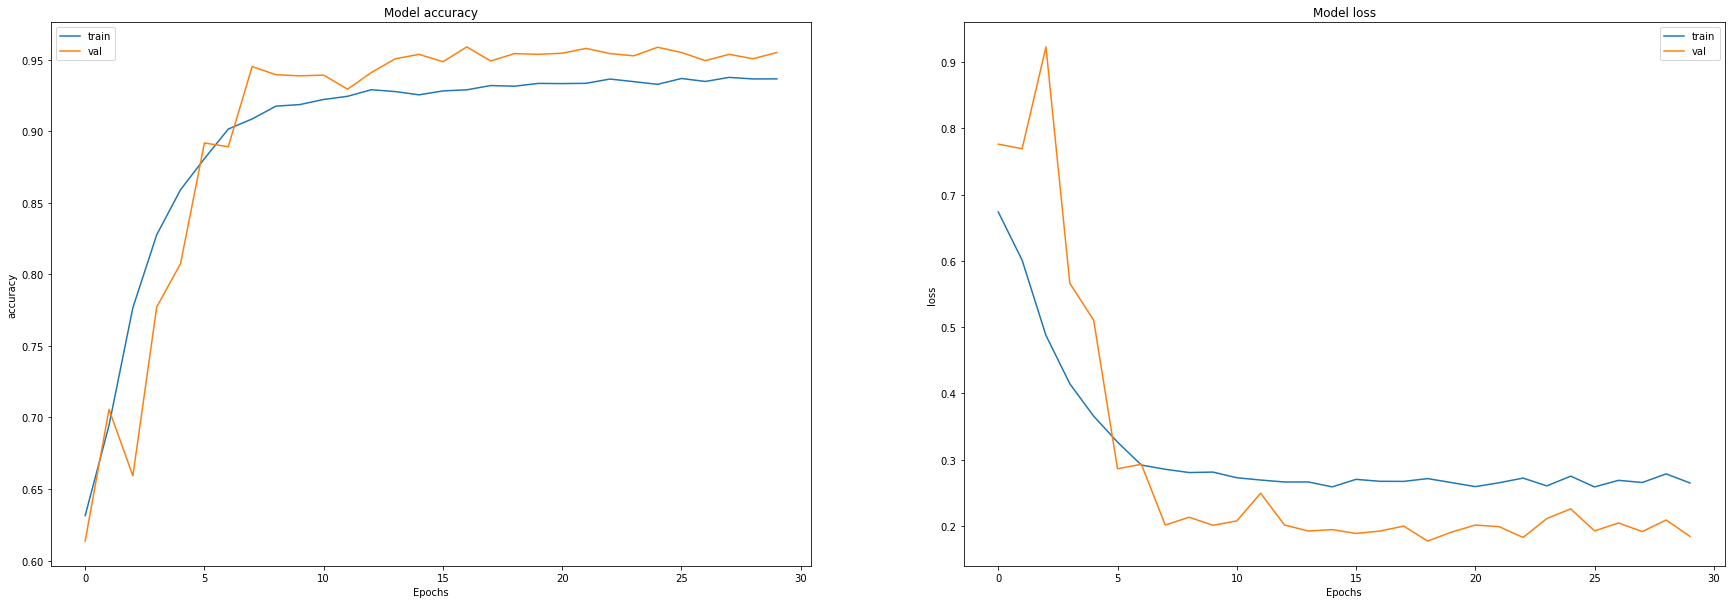

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (30, 10))
ax = ax.ravel()

for i, metric in enumerate(["accuracy", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [ ]:
model.evaluate(validation_generator)

242/242 [==============================] - 5s 20ms/step - loss: 0.1841 - accuracy: 0.9552


[0.1840502917766571, 0.9551581144332886]

# Validation loss = 0.185

# Validation Accuracy = ~ 95 %

   By looking at the loss & accuracy curves, we can observe some sudden steeps. This indicates that there is some noise out there which hinders the model's convergance at regular intervals. Now, we look forward to tune the performance of this custom cnn model to get higher accuracy

# 4. Applying hyperparameter-tuning on CNN

In [ ]:
batch_size=16
x_train_tuned_cnn =  train_datagen.flow_from_dataframe(
dataframe = train_df,
x_col='image_path',
y_col='label',
class_mode='categorical',
target_size=IMAGE_SIZE,
shuffle=False,
batch_size=batch_size,
seed=10)



x_val_tuned_cnn = validation_datagen.flow_from_dataframe(
dataframe = validate_df,
x_col='image_path',
y_col='label',
class_mode='categorical',
target_size=IMAGE_SIZE,
shuffle=False,
batch_size=batch_size,
seed=10)

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
total_test = test_df.shape[0]
batch_size=16

print(f"Training data : {total_train}\nvalidation data : {total_validate}\nTest data : {total_test}")


Found 15432 validated image filenames belonging to 2 classes.
Found 3858 validated image filenames belonging to 2 classes.
Training data : 15432
validation data : 3858
Test data : 8268


In [ ]:
# Define a sequential model
tuned_model = Sequential()

# Add the first convolutional layer with 16 filters and a 3x3 kernel
tuned_model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
# Add max pooling layer with a 2x2 pool size
tuned_model.add(MaxPooling2D(pool_size=(2, 2)))
# Add dropout layer with a rate of 0.2
tuned_model.add(Dropout(0.2))

# Add second convolutional layer with 32 filters and a 3x3 kernel
tuned_model.add(Conv2D(32, (3, 3), activation='relu'))
# Add max pooling layer with a 2x2 pool size
tuned_model.add(MaxPooling2D(pool_size=(2, 2)))
# Add dropout layer with a rate of 0.25
tuned_model.add(Dropout(0.25))

# Add third convolutional layer with 64 filters and a 3x3 kernel
tuned_model.add(Conv2D(64, (3, 3), activation='relu'))
# Add max pooling layer with a 2x2 pool size
tuned_model.add(MaxPooling2D(pool_size=(2, 2)))
# Add dropout layer with a rate of 0.25
tuned_model.add(Dropout(0.25))

# Add flatten layer to convert the output from 2D to 1D
tuned_model.add(Flatten())

# Add a fully connected layer with 1024 units and ReLU activation
tuned_model.add(Dense(1024, activation='relu'))
# Add batch normalization layer
tuned_model.add(BatchNormalization())
# Add dropout layer with a rate of 0.5
tuned_model.add(Dropout(0.5))

# Add a fully connected layer with 512 units and ReLU activation
tuned_model.add(Dense(512, activation='relu'))
# Add batch normalization layer
tuned_model.add(BatchNormalization())
# Add dropout layer with a rate of 0.5
tuned_model.add(Dropout(0.5))

# Add a fully connected layer with 128 units and ReLU activation
tuned_model.add(Dense(128, activation='relu'))
# Add batch normalization layer
tuned_model.add(BatchNormalization())
# Add dropout layer with a rate of 0.5
tuned_model.add(Dropout(0.5))

# Add output layer with 2 units and softmax activation for binary classification
tuned_model.add(Dense(2, activation='softmax'))

# Define Adam optimizer with a learning rate of 0.0001
optimizer = Adam(learning_rate=0.0001)

# Compile the model with categorical crossentropy loss and accuracy metric
tuned_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Print the model summary
tuned_model.summary()

In [ ]:
tuned_model.compile(loss = "categorical_crossentropy" , optimizer = "adam" , metrics = ["accuracy"])
tuned_model_history = tuned_model.fit_generator(
    x_train_tuned_cnn,
    epochs=30,
    validation_data=x_val_tuned_cnn,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size
)


c:\softwares\envs\tfgpu\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
964/964 [==============================] - 79s 81ms/step - loss: 0.7929 - accuracy: 0.5923 - val_loss: 2.3459 - val_accuracy: 0.5013
Epoch 2/30
964/964 [==============================] - 82s 85ms/step - loss: 0.3451 - accuracy: 0.8677 - val_loss: 0.2963 - val_accuracy: 0.8711
Epoch 3/30
964/964 [==============================] - 82s 85ms/step - loss: 0.2657 - accuracy: 0.9111 - val_loss: 0.1938 - val_accuracy: 0.9323
Epoch 4/30
964/964 [==============================] - 84s 87ms/step - loss: 0.2457 - accuracy: 0.9201 - val_loss: 0.2423 - val_accuracy: 0.9313
Epoch 5/30
964/964 [==============================] - 83s 86ms/step - loss: 0.2297 - accuracy: 0.9294 - val_loss: 0.1836 - val_accuracy: 0.9393
Epoch 6/30
964/964 [==============================] - 88s 91ms/step - loss: 0.2234 - accuracy: 0.9316 - val_loss: 0.2296 - val_accuracy: 0.9274
Epoch 7/30
964/964 [==============================] - 83s 86ms/step - loss: 0.2268 - accuracy: 0.9303 - val_loss: 0.1673 - val_accuracy:

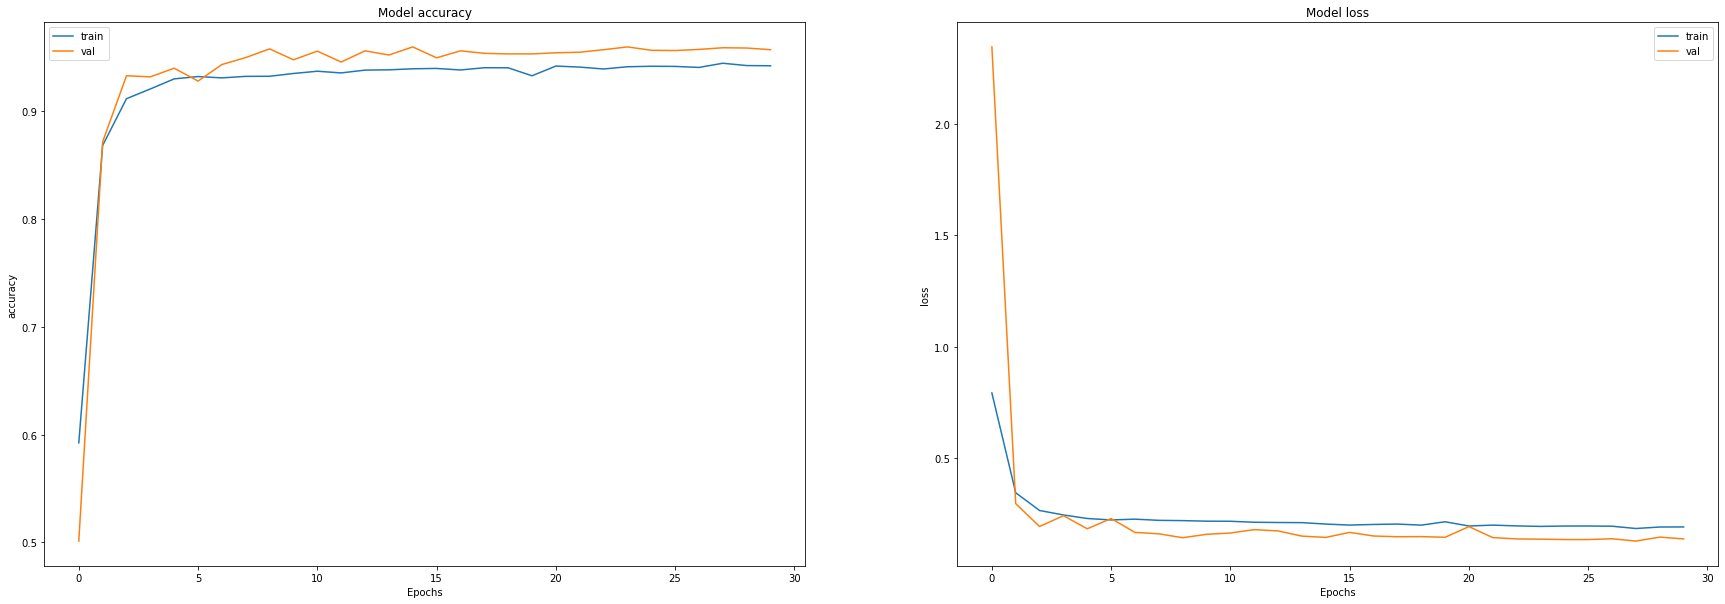

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (30, 10))
ax = ax.ravel()

for i, metric in enumerate(["accuracy", "loss"]):
    ax[i].plot(tuned_model_history.history[metric])
    ax[i].plot(tuned_model_history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

The Accuracy and loss curves are now way smoother than the earlier model

In [ ]:
tuned_model.evaluate(x_val_tuned_cnn)

242/242 [==============================] - 10s 43ms/step - loss: 0.1380 - accuracy: 0.9565


[0.13804449141025543, 0.9564540982246399]

# Validation loss = 0.13

# Validation Accuracy = ~ 96 %

# 5 & 6. Evaluation using various metrics on test set

In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df,
    x_col='image_path',
    y_col='label',
    class_mode='categorical',
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 8268 validated image filenames belonging to 2 classes.


c:\softwares\envs\tfgpu\lib\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


[[3901  245]
 [ 116 4006]]


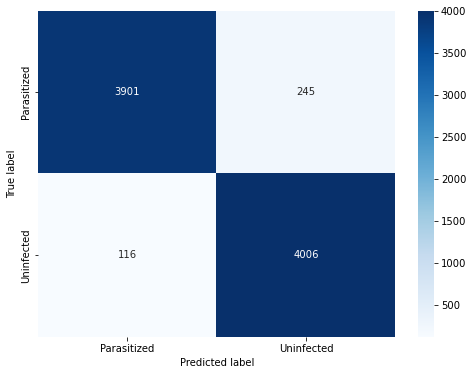

In [ ]:
# make predictions using the model
y_pred = tuned_model.predict_generator(test_generator, steps=test_generator.samples)

# get the true labels
y_true = test_generator.classes

# get the class indices
class_indices = test_generator.class_indices

# get the class names
class_names = list(class_indices.keys())

# get the predicted labels
y_pred = np.argmax(y_pred, axis=1)

# create the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# print the confusion matrix
print(cm)

# plot the confusion matrix
# create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_indices.keys(), yticklabels=class_indices.keys())
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()



## Confusion matrix Readings

TP = 3901, TN = 4096, FP = 116, FN = 245

In [ ]:
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

 Parasitized       0.97      0.94      0.96      4146
  Uninfected       0.94      0.97      0.96      4122

    accuracy                           0.96      8268
   macro avg       0.96      0.96      0.96      8268
weighted avg       0.96      0.96      0.96      8268



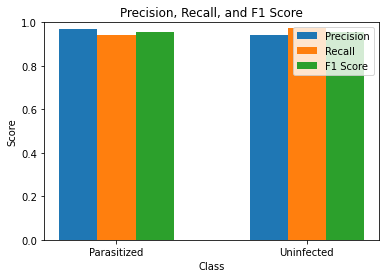

In [ ]:
# calculate precision, recall, f1 score, and support
precision, recall, f1_score, support = precision_recall_fscore_support(y_true, y_pred)

# plot precision, recall, and f1 score
fig, ax = plt.subplots()
x_labels = list(class_indices.keys())
x_pos = np.arange(len(x_labels))
ax.bar(x_pos - 0.2, precision, width=0.2, label='Precision')
ax.bar(x_pos, recall, width=0.2, label='Recall')
ax.bar(x_pos + 0.2, f1_score, width=0.2, label='F1 Score')
ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels)
ax.set_ylim([0, 1])
ax.set_xlabel('Class')
ax.set_ylabel('Score')
ax.set_title('Precision, Recall, and F1 Score')
ax.legend()
plt.show()

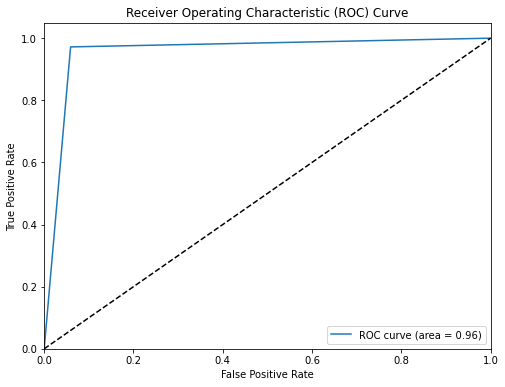

In [ ]:
# calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)

# calculate the AUC ROC
auc_score = auc(fpr, tpr)

# plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

plt.show()


(ROC) curve for the model is 0.96

# 7. Critically evaluate the whole process :

**Introduction about Malaria disease:**

  Malaria is a life-threatening disease caused by Plasmodium parasites that are transmitted to people through the bites of infected female Anopheles mosquitoes called "malaria vectors." It is preventable and curable.3.3 billion people are at risk for contracting malaria, which results in an estimated 200 million infections and 600,000 fatalities each year across 97 countries. (WHO, 2015).

   A drop of the patient's blood spread out as a "blood smear" on a microscope slide can be used to identify malaria parasites. The material is stained (most frequently with the Giemsa stain) before examination in order to give the parasites a unique appearance.health, G. (2018)

**The Process:**

   Firstly,the required libraries for the task has been imported. Then the Malaria dataset has been imported by creating a dataframe containing the image paths and labels.The selected datast was explored by plotting barplot.From that it was identified there are two classes (parazitized and uninfected) and dataset was not imbalanced since each folder have 13779 images. Also, the data is evenly distributed .
    
   The data augmentation techniques were performed using ImageDataGenerator in the pre processing for the training set to improve the diversity. It's a helpful class because it has several functions that let you rescale, rotate, zoom, and flip images, among other things. Thakur, R. (2023) . As the data is a binary classification dataset ,the neural network models VGG16, VGG19 AND CNN can be used. These models are pre trained deep learning models .
   
   The dataset was divided as training , test and validation dataset and used for training the models.I first split the original dataset data_df into two sets. The train_test_split function is used with a test size of 30% and created a training set (train_df) and a test set (test_df).Then the training set got split into two subsets: train_df (updated) and validate_df. The train_test_split function is again used with a test size of 20% and created a new training set (train_df) and a validation set (validate_df).

Total training samples : 15432
Total validation samples : 3858
Total Test samples : 8268

*VGG19 Model:*
     VGG19 has 19 layers total (16 convolutional layers, 3 fully connected layers, 5 MaxPool layers, and 1 SoftMax layer). Sec., Dr.I. (2021).The model's input shape is set to (224, 224, 3), and it is initialized with pre-trained weights. The VGG19 model is added as a layer to the sequential model and is compiled using the Adam optimizer.I specified 10 epochs by instructing the model to go through the entire training dataset 10 times .The model is trained using the training and validation data generators. The code evaluates the trained VGG19 model on the validation set and plots the accuracy and loss curves.
     
   The VGG19 model has lower accuracy (49%) compared to the VGG16 model, possibly due to its deeper architecture which may lead to overfitting and slower training. The valiadtion loss (69%) is higher than other models whhich indicates the model doesnt perform well.Therefore, it is not always the case that a deeper model will perform better, as it depends on the specific dataset.


*VGG16 Model:*
    On the other hand, vgg16 is distinctive in that it uses only 16 weighted layers . This vision model architecture is regarded as one of the greatest. Thakur, R. (2023) .Also, VGG16 model has fewer layers compared to VGG19 . It follows a similar process as the previous VGG19 model but with some differences in the architecture. All the layers were frozen to prevent their weights from being updated during training. A classification head with Flatten layer , Dense layer with 4096 units and the prediction layer has a single unit with a sigmoid activation function wer added to the model.It is compiled with the Adam optimizer, binary crossentropy loss, and accuracy metric.Used 30 epochs for better training.Finally, the metrics are plotted for both the training and validation data. The model performance was evaluated on the validation dataset and plotted.
    
   It has 90 percent accuracy and validation loss of 18 percent.The VGG16 model has higher accuracy compared to the VGG19 model. possibly due to VGG19'S deeper architecture which may lead to overfitting and slower training. On the other hand, the VGG16 model has fewer layers and is pretrained on a larger dataset, resulting in better feature extraction capabilities and better generalization performance. Supporting the previous insight that for the dataset, a simpler architecture works better than a complex one as vgg19.

*CNN Model:*
    In terms of deep learning architectures, convolutional neural networks (CNN) are among the most often used. Deep learning has drawn more interest as a result of its usefulness in real-world applications.  Theckedath, D. and Sedamkar, R.R. (2020). The model consists of convolutional layers, max-pooling layers, dropout layers, and dense layers. It is compiled and trained for a specified number of epochs.  I have added three Conv2D and MaxPooling layers and dropout layers . After that, I have included the BatchNormalization layers followed by which the input layer has been added using the Flatten() function.I trained the model for 30 epochs.I plotted a graph to visualize the training and validation accuracy and loss .
    
   It shows an accuracy of 95.When compared to vgg16 which performed signifcantly better than vgg19, The custom CNN, despite its simpler architecture, has achieved a high validation accuracy of 95%, which is comparable to the VGG16 model's accuracy of 90%.there is some noise out there which hinders the model's convergence at regular intervals. Now, we look forward to tune the performance of this custom cnn model and get smooth training curves with hopefully a lesser loss and higher accuracy

   CNN achieved the best accuracy with 95 percent out of all the three models . To increase more accuracy of the model , hyper parameter tuning was applied


  

**Hyper parameter tuning :**
Hyper tuning was applied to CNN architecture by modifying the number of filters and adding more layers. It trained and evaluated the tuned model.The below tuning methods were applied to the model to increase the performance

•	Induced the feature pyramid culture by decreasing the no. of filters in the initial convolutional layers and adding
 more dense layers in the classification head, resulting in a more powerful model with increased capacity for feature extraction and classification.Reduced the dropout rate in the initial layers to retain more information from the input, allowing the model to learn more effectively from the data.Changed the optimizer from RMSprop to Adam, which is known to perform well on a wide range of deep learning tasks, resulting in better optimization and faster convergence of the training process.

The accuracy got after tuning the model is 96 percent which shows the good performance of the model after tuning.



  I evaluated the model's performance by analyzing the confusion matrix, which showed the correct and incorrect predictions for parasitized and uninfected classes.

**CONFUSION MATRIX READINGS:**
•	True Positives (TP) show the number of classified malaria-infected cells. In this case, the model identified 3901 cells correctly as infected with malaria.

•	True Negatives (TN) signify the number of classified non-infected cells. The model correctly identified 4096 cells as non-infected

•	False Positives (FP) are the instances where the model incorrectly classified non-infected cells as infected. In this case, 116 cells were labeled as infected with malaria

•	False Negatives (FN) represent the number of malaria-infected cells that were incorrectly classified as non-infected. The model failed to identify 245 cells as infected with malaria.

   Even though CNN model missed to detect 245 infected cells, leading to false-negative results , it identified 3901 infected cells and 4096 non infected cells correctlt . This shows the model exhibits reasonably good performance in terms of detecting malaria-infected cells (TP) and non-infected cells (TN).

**PRECISION :**
   It is calculated as the sum of the true positives and false positives divided by the number of true positives.. Koehrsen, W. (2023) For the class "Parasitized", the precision is 0.97, which means that 97% of the images predicted as "Parasitized" were actually Parasitized. Similarly, for the class "Uninfected", the precision is 0.94, which means that 94% of the images predicted as "Uninfected" were actually Uninfected.
   
**RECALL :**
 Recall is calculated mathematically as the product of the number of true positives divided by the sum of the true positives and false negatives. Koehrsen, W. (2023)  For the class "Parasitized", the recall is 0.94, which means that 94% of the actual Parasitized images were correctly identified as Parasitized. Similarly, for the class "Uninfected", the recall is 0.97, which means that 97% of the actual Uninfected images were correctly identified as Uninfected.

**F1-SCORE :**
It is the harmonic mean of precision and recall, and provides a single score that balances both these metrics. Koehrsen, W. (2023)   For both the classes, the F1-score is 0.96, which means that the model is performing equally well on both the classes.

**Support:**
It is the number of samples in each class.

In summary, the model is performing well with an overall accuracy of 0.96, and good precision, recall and F1-score for both the classes.

**ROC CURVE :**
The performance of two or more diagnostic tests is compared using the ROC curve, which is used to evaluate a test's overall diagnostic performance. It is also used to choose the best cut-off value for assessing whether a disease is present or not. Nahm, F.S. (2022) .The closer the AUC-ROC value is to 1, the better the model's performance.The area under the receiver operating characteristic (ROC) curve for the model is 0.96, indicating that the model has good predictive performance.



**CONCLUSION :**
    
   To conclude, custom CNN is the best model for the selected Malaria cell image dataset to identify the infected and non infected cells with the highest accuracy of 96 percent .

# REFERENCES:
health, G. (2018) CDC - Malaria - diagnosis &amp; treatment (United States) - diagnosis (U.S.), Centers for Disease Control and Prevention. Available at: https://www.cdc.gov/malaria/diagnosis_treatment/diagnosis.html#:~:text=Malaria%20parasites%20can%20be%20identified,the%20parasites%20a%20distinctive%20appearance. (Accessed: 15 May 2023).

Theckedath, D. and Sedamkar, R.R. (2020) ‘Detecting affect states using VGG16, Resnet50 and SE-Resnet50 Networks’, SN Computer Science, 1(2). doi:10.1007/s42979-020-0114-9.

Acharya, P., Grover, M. and Tatu, U. (2013) ‘Disease system, malaria’, Encyclopedia of Systems Biology, pp. 584–588. doi:10.1007/978-1-4419-9863-7_565.

Sec., Dr.I. (2021) VGG-19 Convolutional Neural Network, All about Machine Learning. Available at: https://blog.techcraft.org/vgg-19-convolutional-neural-network/ (Accessed: 14 May 2023).

Beginner’s Guide to VGG16 implementation in Keras, Built In. Available at: https://builtin.com/machine-learning/vgg16 (Accessed: 15 May 2023).

Thakur, R. (2023) Beginner’s Guide to VGG16 implementation in Keras, Built In. Available at: https://builtin.com/machine-learning/vgg16 (Accessed: 15 May 2023).

Koehrsen, W. (2023) Precision and recall: How to evaluate your classification model, Built In. Available at: https://builtin.com/data-science/precision-and-recall (Accessed: 15 May 2023).

Nahm, F.S. (2022) Receiver operating characteristic curve: Overview and practical use for clinicians, Korean journal of anesthesiology. Available at: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8831439/#:~:text=The%20ROC%20curve%20is%20used,or%20absence%20of%20a%20disease. (Accessed: 15 May 2023).

